In [1]:
!pip install unsloth 
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.6/191.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 83.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.1/253.1 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 41.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:

In [2]:
!pip install trl

In [40]:
from trl import SFTTrainer, SFTConfig


In [4]:
!pip install wandb


In [5]:
from unsloth import FastLanguageModel
import torch
from unsloth import is_bfloat16_supported # checks if hardware supports bfloat16 precision datatype
from huggingface_hub import login
from transformers import TrainingArguments
from datasets import load_dataset
import wandb
from kaggle_secrets import UserSecretsClient

<ipython-input-5-79d4e75f10b8>:1: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [6]:
user_secrets= UserSecretsClient()
hugging_face_token= user_secrets.get_secret("huggingface_api")
wdb_token= user_secrets.get_secret("wandb_api")

login(hugging_face_token)

wandb.login(key=wdb_token)
run= wandb.init(
    project=" FT-Deepseek",
    job_type="training", 
    anonymous="allow"    
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rutuja-kokate (rutuja-kokate-san-jose-state-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
max_seq_length= 2048 # Maximum sequence length a model can handle ie # of tokens that can be processed at once
dtype= None # in this way model can auto detect the data type
load_in_4bit= True # Enables 4 bit quantization (memory efficient), 4 bit quantization reduces the precision of model weights making them smaller and faster while keeping most of its accuracy.
# Instead of using 32-bit or 64 bit numbers we compress them to 4 bit values, allowing LLMs to run efficiently on consumer GPU without using massive amount of memory.

model, tokenizer= FastLanguageModel.from_pretrained(
    model_name= "unsloth/DeepSeek-R1-Distill-Llama-8B",  # smaller version of deepseek model
    max_seq_length= max_seq_length, 
    dtype= dtype, 
    load_in_4bit=load_in_4bit, 
    token= hugging_face_token
)

# FastLanguageModel is a wrapper function around Hugging face model that lets us run and inference the model more efficiently and faster using unsloth

==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
# Updated training prompt style to add </think> tag 
# Define a system prompt under prompt_style 
prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. 
Please answer the following medical question. 

### Question:
{}

### Response:
<think>{}"""


In [9]:
FastLanguageModel.for_inference(model)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((409

In [11]:
# Creating a test medical question for inference
question = """A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or 
              sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, 
              what would cystometry most likely reveal about her residual volume and detrusor contractions?"""
# formatiing the question to prompt_stype and tokenize it
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")# make sure to return pytorch tensors and we set "cuda" to enable GPU inference

In [12]:
outputs= model.generate(
    input_ids= inputs.input_ids, 
    attention_mask= inputs.attention_mask, 
    max_new_tokens=1200, 
    use_cache= True  # if we use the same question action, it will be able to respond to the question much more quickly
)

In [14]:
response= tokenizer.batch_decode(outputs) # decoding the tokenized outputs to human readable format
print(response[0])

<｜begin▁of▁sentence｜>Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. 
Please answer the following medical question. 

### Question:
A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or 
              sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, 
              what would cystometry most likely reveal about her residual volume and detrusor contractions?

### Response:
<think>
Okay, so I'm trying to figure out what the cystometry would show for this 61-year-old woman. Let me start by breaking down the informati

In [16]:
print(response[0].split("### Response")[1])

:
<think>
Okay, so I'm trying to figure out what the cystometry would show for this 61-year-old woman. Let me start by breaking down the information given.

First, she has a history of involuntary urine loss when she coughs or sneezes. That makes me think about stress urinary incontinence. I remember that stress incontinence is usually due to the bladder not fully emptying, especially when there's increased pressure like from coughing.

She doesn't leak at night, which is interesting. Usually, people with overactive bladder syndrome or urgency might leak at night because the bladder can't hold it. But here, it's more about the physical stress causing leakage, not the bladder being too sensitive.

She underwent a gynecological exam and Q-tip test. I'm a bit rusty on the Q-tip test. From what I recall, the Q-tip is a small catheter used to measure intra-abdominal pressure and bladder pressure. The test involves inserting it into the vagina and then applying pressure to see how the bladde

### Fine tuning

In [17]:
# Updated training prompt style to add </think> tag 
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. 
Please answer the following medical question. 

### Question:
{}

### Response:
<think>
{}
</think>
{}"""


## Dataset: https://huggingface.co/datasets/FreedomIntelligence/medical-o1-reasoning-SFT?row=32

In [19]:
dataset= load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en", split="train[0:500]", trust_remote_code=True) # trust_remote allows downloading dataset
dataset

medical_o1_sft.json:   0%|          | 0.00/74.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25371 [00:00<?, ? examples/s]

Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 500
})

In [20]:
dataset[1]

{'Question': 'A 45-year-old man with a history of alcohol use, who has been abstinent for the past 10 years, presents with sudden onset dysarthria, shuffling gait, and intention tremors. Given this clinical presentation and history, what is the most likely diagnosis?',
 'Complex_CoT': "Alright, let’s break this down. We have a 45-year-old man here, who suddenly starts showing some pretty specific symptoms: dysarthria, shuffling gait, and those intention tremors. This suggests something's going wrong with motor control, probably involving the cerebellum or its connections.\n\nNow, what's intriguing is that he's had a history of alcohol use, but he's been off it for the past 10 years. Alcohol can do a number on the cerebellum, leading to degeneration, and apparently, the effects can hang around or even appear long after one stops drinking.\n\nAt first glance, these symptoms look like they could be some kind of chronic degeneration, maybe something like alcoholic cerebellar degeneration, 

In [22]:
EOS_TOKEN= tokenizer.eos_token # prevents the model from generating beyond the expected response by adding End of Sequence token
EOS_TOKEN

'<｜end▁of▁sentence｜>'

In [26]:
# defining formatting prompt

def formatting_prompts_func(examples):
    inputs= examples["Question"]
    cots= examples["Complex_CoT"]
    outputs= examples["Response"]

    texts=[]
    for input, cot, output in zip(inputs, cots, outputs):
        text= train_prompt_style.format(input, cot, output)+ EOS_TOKEN
        texts.append(text)
    return {
        "text":texts
    }

In [27]:
dataset_finetune= dataset.map(formatting_prompts_func, batched=True)
dataset_finetune["text"][0]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

"Below is an instruction that describes a task, paired with an input that provides further context. \nWrite a response that appropriately completes the request. \nBefore answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.\n\n### Instruction:\nYou are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. \nPlease answer the following medical question. \n\n### Question:\nA 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, what would cystometry most likely reveal about her residual volume and detrusor contractions?\n\n### Response:\n<think>\nOkay, let's think about this step by step. There's a 61-year-old woman here who's been dealing with involuntary urine leakages whenever she's doing something that ups her ab

## we implement LoRA using PEFT model (Parameter efficient fine tuning), it wraps the model with LoRA modifications

In [33]:
model_lora= FastLanguageModel.get_peft_model(
    model, 
    r=16, # size of trainable adapters, higher means we are adapting more weights, lower means we are adapting fewer weights(or we are being efficient).
    target_modules= [
        "q_proj", # Query projection
        "k_proj", # Key projection
        "v_proj", # Value projection
        "o_proj", # output projection
        "gate_proj", # feed forward layer
        "up_proj", 
        "down_proj"
    ],   # defines which transformers layers of deepseek that we will be adapting using LoRA
    lora_alpha=16,  # Higher this number is the more weight changes the LoRA process will do the layers
    lora_dropout=0,   # No dropout, meaning how much info you retain in weight updating process
    bias="none",     # specifies whether the LoRa layers that we are updating should learn bias terms. (Memory saving technique)
    use_gradient_checkpointing="unsloth",  #This saves memory by recomputing the activations instead of storing them. Used for FT large datasets with Long contexts
    random_state=3407,  # random seed
    use_rslora= False, 
    loftq_config=None, # 4 bit fine tuning quantization, we disable this as we already have 4 bit quantization
)

Unsloth 2025.3.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [43]:
## we initialize supervised fine tuning trainer to from trl to fine tune model efficiently on a dataset.

trainer= SFTTrainer(
    model=model_lora, 
    tokenizer= tokenizer, 
    train_dataset=dataset_finetune, 
    dataset_text_field= "text",  # field we will be using to train
    max_seq_length= max_seq_length, 
    dataset_num_proc=2, 
    
    # Define training arguements
    args= TrainingArguments(
        per_device_train_batch_size=2, # sincw we have 2 gpu's
        gradient_accumulation_steps=4, # Number of steps until when the gradient accumulates before weight update
        num_train_epochs=1, 
        warmup_steps=5, ## learning rate
        max_steps=60, 
        learning_rate=2e-4, 
        fp16=not is_bfloat16_supported(), 
        bf16= is_bfloat16_supported(), 
        logging_steps=10, 
        optim="adamw_8bit", 
        weight_decay=0.01, # allows regularization to prevent overfitting
        lr_scheduler_type="linear", 
        seed= 3407, 
        output_dir="outputs",   
    ),    
)

In [44]:
trainer_stats=trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500 | Num Epochs = 2 | Total steps = 60
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040/4,670,623,744 (0.90% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,1.914200
20,1.421100
30,1.366100
40,1.328500
50,1.295100
60,1.326900


In [45]:
wandb.finish()

train/epoch,▁▂▄▅▇██
train/global_step,▁▂▄▅▇██
train/grad_norm,█▄▂▁▁▂
train/learning_rate,█▇▅▄▂▁
train/loss,█▂▂▁▁▁
total_flos,4.008346716644966e+16
train/epoch,1.896
train/global_step,60
train/grad_norm,0.20195
train/learning_rate,0
train/loss,1.3269


In [46]:
question = """A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing 
              but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, 
              what would cystometry most likely reveal about her residual volume and detrusor contractions?"""

# Load the inference model using FastLanguageModel (Unsloth optimizes for speed)
FastLanguageModel.for_inference(model_lora)  # Unsloth has 2x faster inference!

# Tokenize the input question with a specific prompt format and move it to the GPU
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

# Generate a response using LoRA fine-tuned model with specific parameters
outputs = model_lora.generate(
    input_ids=inputs.input_ids,          # Tokenized input IDs
    attention_mask=inputs.attention_mask, # Attention mask for padding handling
    max_new_tokens=1200,                  # Maximum length for generated response
    use_cache=True,                        # Enable cache for efficient generation
)

# Decode the generated response from tokenized format to readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the model's response part after "### Response:"
print(response[0].split("### Response:")[1])


<think>
Alright, let's think about this. We have a 61-year-old woman who's been dealing with involuntary urine loss whenever she coughs or sneezes. That sounds like a classic case of urinary incontinence, probably stress incontinence. Now, stress incontinence usually means the bladder isn't closing properly, so when she coughs, it just pops open and she loses urine.

Now, let's consider what happens in cystometry. This test measures how much urine is left in the bladder and how the detrusor muscle contracts. If she has stress incontinence, the bladder might not be able to hold much urine at all because it's not closing properly. So, when we do the test, we might find that her residual volume is low. That makes sense because if the bladder isn't closing, it doesn't hold much.

Now, about the detrusor contractions. If the bladder can't close, the detrusor might not contract strongly enough to push the urine out. So, during the cystometry, we might not see strong contractions. This is be

In [47]:
question = """A 59-year-old man presents with a fever, chills, night sweats, and generalized fatigue, 
              and is found to have a 12 mm vegetation on the aortic valve. Blood cultures indicate gram-positive, catalase-negative, 
              gamma-hemolytic cocci in chains that do not grow in a 6.5% NaCl medium. 
              What is the most likely predisposing factor for this patient's condition?"""

print(response[0].split("### Response:")[1])


<think>
Okay, let's see what's going on here. We have a 59-year-old man with symptoms like fever, chills, night sweats, and fatigue. That sounds pretty serious, like a systemic infection. And the key clue is that he's got a vegetation on his aortic valve. That's concerning because it means he might have an infection of the heart valves, which is called endocarditis.

Now, the blood cultures show gram-positive, catalase-negative, gamma-hemolytic cocci in chains. Hmm, I remember that gram-positive, catalase-negative cocci in chains are usually Streptococcus. But wait, Streptococcus doesn't grow in high salt concentrations like 6.5% NaCl. Oh, but these are gram-positive, so I need to think again.

Oh, right! Enterococcus doesn't grow in high salt either. But wait, Enterococcus is gram-positive, catalase-negative, and can be part of the normal flora. But in this case, they're in chains, which is more of a Streptococcus trait. Hmm, this is confusing.

Oh, wait a minute! If these are gram-p

In [48]:
question = """A 6-year-old girl develops an itchy rash with erythematous scaly plaques on her fingers after receiving silver rings as a gift. Considering the materials that commonly cause allergic contact dermatitis, what metal alloy is most likely responsible for her symptoms?"""

# Tokenize the input question with a specific prompt format and move it to the GPU
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

# Generate a response using LoRA fine-tuned model with specific parameters
outputs = model_lora.generate(
    input_ids=inputs.input_ids,          # Tokenized input IDs
    attention_mask=inputs.attention_mask, # Attention mask for padding handling
    max_new_tokens=1200,                  # Maximum length for generated response
    use_cache=True,                        # Enable cache for efficient generation
)

# Decode the generated response from tokenized format to readable text
response = tokenizer.batch_decode(outputs)

# Extract and print only the model's response part after "### Response:"
print(response[0].split("### Response:")[1])


<think>
Alright, let's think about what's happening here. The girl has an itchy rash, and it's on her fingers. That makes me think of contact dermatitis, which is often caused by something she came into contact with. Now, she just got these silver rings. Hmm, silver is pretty common, but it's not the only metal used in jewelry. I remember hearing about alloys, which are mixtures of metals.

Let's consider what these alloys are made of. There's gold, but that's usually for jewelry and would be more expensive. Then there's nickel, which is known for causing allergic reactions, especially in items like earrings or jewelry. Nickel is a common culprit for contact dermatitis because a lot of jewelry uses it.

Let's not forget about stainless steel. It's used a lot in jewelry, too. Stainless steel is made of steel and chromium. Chromium can cause allergic reactions, but I think it's less common than nickel. So, nickel might still be the main suspect here.

Okay, let's tie this together. The 

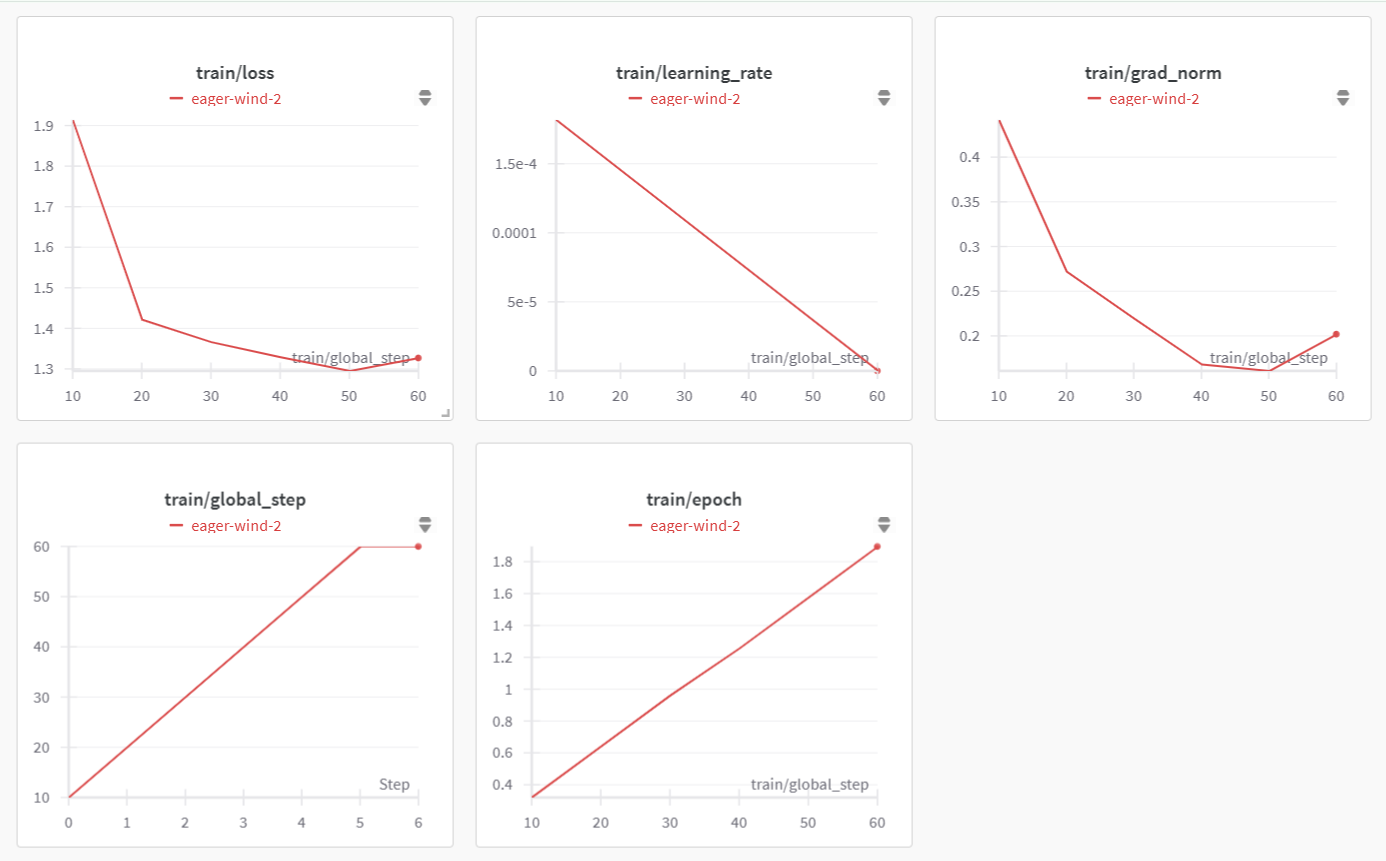